<a href="https://colab.research.google.com/github/quentinnorris/miniproject3/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import platform
import io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive/'My Drive'/'COMP551'/    

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
test_max_x  train_max_x  train_max_y.csv


In [0]:
datapath = 'gdrive/My Drive/COMP551/'

In [0]:
train_X=pd.read_pickle(datapath+"train_max_x")
test_X=pd.read_pickle(datapath+"test_max_x")
train_y=pd.read_csv(datapath+"train_max_y.csv")

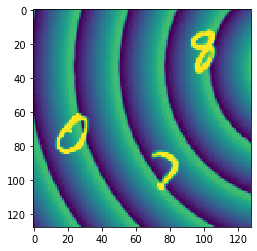

In [0]:
plt.imshow(train_X[9])

In [0]:
def preprocessing(x):
  x[x<250] = 0
  return x

In [0]:
#train_X = preprocessing(train_X)
#test_X = preprocessing(test_X)

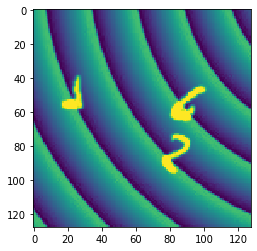

In [0]:
plt.imshow(train_X[0])

In [0]:
class Dataset(Dataset):
    
    def __init__(self, x, y):
        self.data=x
        self.labels=y
        if y is None:
            self.labels=pd.DataFrame(np.zeros([len(x),2]))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        image = torch.from_numpy(image)
        label=-1
        if self.labels is not None:
            label = self.labels.iloc[index,1]
            
        return image, label

In [0]:
train_image=Dataset(train_X,train_y)
test_image=Dataset(test_X,None)

train_size = int(0.8 * len(train_image))
test_size = len(train_image) - train_size

train,valid=torch.utils.data.dataset.random_split(train_image,[train_size,test_size])

In [0]:
BATCH_SIZE=100

train_loader=torch.utils.data.DataLoader(train,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid,batch_size=BATCH_SIZE,shuffle=False)
test_loader=torch.utils.data.DataLoader(test_image,batch_size=BATCH_SIZE,shuffle=False)     

In [0]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
resnet = ResNet(**net_args)
use_gpu=torch.cuda.is_available()
print("GPU Available:{}".format(use_gpu))
if use_gpu:
    resnet.cuda()

GPU Available:True


In [0]:
criterion=nn.CrossEntropyLoss()

In [0]:
def trainResNet(epoch, model,train_loader,optimizer):
    model.train()

    total_loss=0;
    correct=0;

    for i, (image,label) in enumerate(train_loader):

        optimizer.zero_grad()

        image = Variable(image.resize_(BATCH_SIZE, 1, 128, 128))
        
        if use_gpu:
            image=image.cuda()
            label=label.cuda()

        output=model(image)

        loss=criterion(output,label)

        loss.backward()

        optimizer.step()

        total_loss+=loss
        pred_classes = output.data.max(1,keepdim=True)[1]
        correct += pred_classes.eq(label.data.view_as(pred_classes)).sum().double()
       
    mean_loss=total_loss/len(train_loader.dataset)
    acc=correct/len(train_loader.dataset)

    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))

    return mean_loss, acc

In [0]:
def evalResNet(model,eval_loader):
  
    model.eval()

    total_loss=0
    correct=0

    for i, (image,label) in enumerate(eval_loader):

        optimizer.zero_grad()

        image = Variable(image.resize_(BATCH_SIZE, 1, 128, 128))
        
        if use_gpu:
            image=image.cuda()
            label=label.cuda()

        output=model(image)

        loss=criterion(output,label)

        loss.backward()

        optimizer.step()

        total_loss+=loss

        pred_classes=output.data.max(1,keepdim=True)[1]
        correct+=pred_classes.eq(label.data.view_as(pred_classes)).sum().double()
      
    mean_loss=total_loss/len(eval_loader.dataset)
    acc=correct/len(eval_loader.dataset)  

    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. *acc)) 

    return mean_loss, acc

In [0]:
optimizer=optim.Adam(resnet.parameters(),lr=0.0001)
# Number of epochs 
numEpochs = 100

# empty lists 
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

# traininng 
for epoch in range(1, numEpochs + 1):
    
    # train() function
    train_loss, train_acc = trainResNet(epoch, resnet, train_loader, optimizer)
    
    # eval() functionn
    test_loss, test_acc = evalResNet(resnet, valid_loader)    
    
    # append lists for plotting and printing 
    train_losses.append(train_loss)    
    test_losses.append(test_loss)
    
    train_accuracies.append(train_acc)    
    test_accuracies.append(test_acc)
    
print("\n\n\nOptimization ended.\n") 

Train Epoch: 1   Avg_Loss: 0.01902   Acc: 10451.0/40000 (26.128%)
Eval:  Avg_Loss: 0.01901   Acc: 2551.0/10000 (25.510%)
Train Epoch: 2   Avg_Loss: 0.01822   Acc: 12053.0/40000 (30.133%)
Eval:  Avg_Loss: 0.01930   Acc: 2508.0/10000 (25.080%)
Train Epoch: 3   Avg_Loss: 0.01852   Acc: 11571.0/40000 (28.928%)
Eval:  Avg_Loss: 0.01765   Acc: 3338.0/10000 (33.380%)
Train Epoch: 4   Avg_Loss: 0.01555   Acc: 17450.0/40000 (43.625%)
Eval:  Avg_Loss: 0.01804   Acc: 3134.0/10000 (31.340%)
Train Epoch: 5   Avg_Loss: 0.01265   Acc: 22876.0/40000 (57.190%)
Eval:  Avg_Loss: 0.01961   Acc: 2475.0/10000 (24.750%)
Train Epoch: 6   Avg_Loss: 0.01406   Acc: 20784.0/40000 (51.960%)
Eval:  Avg_Loss: 0.01152   Acc: 6067.0/10000 (60.670%)
Train Epoch: 7   Avg_Loss: 0.00982   Acc: 27135.0/40000 (67.838%)
Eval:  Avg_Loss: 0.00981   Acc: 6665.0/10000 (66.650%)
Train Epoch: 8   Avg_Loss: 0.00858   Acc: 28846.0/40000 (72.115%)
Eval:  Avg_Loss: 0.00850   Acc: 7152.0/10000 (71.520%)
Train Epoch: 9   Avg_Loss: 0.007

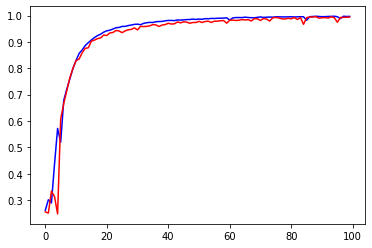

In [0]:
plt.plot(train_accuracies, color="blue", label="train")
plt.plot(test_accuracies, color="red",label="validation")
plt.show()

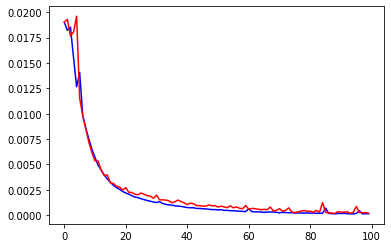

In [0]:
plt.plot(train_losses, color="blue", label="train")
plt.plot(test_losses, color="red",label="validation")
plt.show()

In [0]:
predictions=[]

for i, (image,label) in enumerate(test_loader):
    image = Variable(image.resize_(BATCH_SIZE, 1, 128, 128))
    if use_gpu:
        image=image.cuda()
        label=label.cuda()

    prediction=resnet(image)
    pred_classes=prediction.data.max(1,keepdim=True)[1]
    predictions.append(pred_classes)

In [0]:
results=[]
for i in predictions:
    for j in i:
        results.append(j.item())

In [0]:
print(results)

[9, 6, 4, 9, 5, 8, 2, 4, 5, 9, 4, 9, 8, 9, 9, 6, 8, 7, 4, 6, 7, 7, 6, 5, 8, 9, 5, 6, 8, 6, 2, 9, 3, 8, 7, 6, 9, 8, 8, 8, 9, 2, 8, 9, 9, 4, 8, 9, 9, 9, 5, 7, 7, 9, 7, 4, 8, 6, 6, 9, 8, 5, 9, 8, 8, 8, 8, 4, 7, 1, 7, 9, 7, 8, 9, 7, 9, 5, 6, 2, 8, 9, 7, 6, 9, 9, 8, 3, 7, 9, 7, 9, 5, 8, 8, 9, 5, 5, 7, 8, 9, 9, 8, 9, 5, 9, 9, 5, 9, 9, 6, 8, 5, 4, 9, 8, 7, 6, 9, 6, 6, 4, 7, 8, 8, 8, 7, 4, 8, 8, 6, 8, 6, 5, 2, 0, 7, 6, 7, 7, 3, 3, 8, 6, 6, 3, 8, 8, 8, 9, 7, 6, 6, 9, 2, 4, 7, 9, 8, 6, 6, 7, 7, 8, 1, 5, 1, 5, 9, 4, 8, 7, 9, 9, 7, 9, 7, 9, 8, 9, 7, 9, 4, 8, 8, 4, 8, 6, 7, 8, 9, 9, 7, 3, 9, 9, 9, 6, 9, 8, 8, 9, 6, 7, 3, 8, 9, 8, 3, 9, 8, 7, 9, 8, 8, 6, 9, 6, 9, 9, 3, 9, 5, 3, 7, 9, 8, 8, 7, 7, 7, 4, 6, 8, 5, 8, 4, 8, 3, 9, 9, 6, 6, 7, 7, 9, 4, 3, 8, 9, 4, 8, 7, 9, 6, 5, 9, 8, 8, 9, 2, 2, 8, 8, 9, 8, 8, 6, 6, 9, 7, 8, 6, 7, 9, 7, 8, 7, 9, 7, 8, 9, 8, 6, 6, 7, 5, 8, 8, 3, 8, 8, 6, 8, 7, 9, 8, 6, 9, 4, 9, 5, 7, 6, 9, 9, 8, 4, 9, 8, 6, 8, 6, 6, 8, 9, 4, 9, 7, 9, 8, 6, 7, 8, 7, 5, 7, 7, 6, 4, 5, 9, 8, 

In [0]:
df=pd.DataFrame(results,columns=['Label'])
df.index.name = 'Id'
file=df.to_csv()

In [0]:
from google.colab import files

with open('resnet.csv','w') as f:
    f.write(file)
    
files.download('resnet.csv')